## Lab 8:  Clustering
Environmental justice (EJ) seeks to ensure that all communities, regardless of socioeconomic status or demographic background, have equal access to clean air, water, and, in the form of energy justice, access to renewable energy resources while minimizing exposure to environmental hazards. In this lab, we will apply clustering analysis to explore how U.S. counties group together based on renewable energy potential, demographic characteristics, and environmental risk factors.

The EEIP dataset was collated by the National Renewable Energy Lab (NREL) and contains a large set of features from multiple other databases including SLOPE (renewable energy potential) and EJSCREEN (environmental risk indicators).

Link to metadata: https://ucsb.box.com/s/x3olvh3rd8w5h7xz8jnm3v8g3t4ajjsg

First you will step through a guided clustering exploration of renewable energy production potential.  Then you will formulate a question of your own that brings in an environmental justice component.


### Step 0: Load Libraries and Data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns
# Load the EEIP dataset 
eeip_data = pd.read_csv("/courses/EDS232/Data/eeip.data.csv")


## Part I:
In this part, we will step through an analysis that examines how US counties cluster in their potential production of renewable energy.  

### Step 1: Exploratory Data Analysis

First we need to check for missing data and remove incomplete rows. Since clustering is a distance-based technique, we also need to ensure that the features used for clustering are scaled appropriately to prevent dominant features from skewing results.  For our first analysis, use the following variables from the SLOPE dataset related to energy production potential as your features: 
- `utility_pv_technical_generation_potential_mwh`
- `residential_pv_technical_generation_potential_mwh`
- `land_based_wind_technical_generation_potential_mwh`
- `commercial_pv_technical_generation_potential_mwh`

*Information on these variables is available on line 7 of the ColumnsExplained tab of the metadata*

Once you have removed incomplete rows and scaled, print the shape of your processed dataframe. 

In [29]:
# Set display option
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Explore data

#eeip_data.shape
eeip_data.info()

# Check for missing data
eeip_data.isnull()
missing = eeip_data.isnull().sum()
#print(missing)
#eeip_data.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Columns: 152 entries, county_fips to tsdfprox_5_prop
dtypes: float64(138), int64(12), object(2)
memory usage: 3.6+ MB


Many columns have more than two-thirds of their values as NaN. To clean the dataset, columns with over two-thirds missing values will be removed to retain only those with sufficient data, and rows with any remaining NaN values will be dropped to ensure a complete dataset.

In [3]:
# Drop columns with more than 2/3 missing values
eeip_clean = eeip_data.dropna(thresh=len(eeip_data)*(2/3), axis=1)
# Remove incomplete rows
eeip_clean = eeip_clean.dropna()

# Select numeric rows except for county_fips
numeric_cols = eeip_clean.select_dtypes(include = 'number').drop(columns=['county_fips'])

# Initialize a scaler
scaler = StandardScaler()
# Scale numeric rows
numeric_scaled = scaler.fit_transform(numeric_cols)

# Add back objects columns to the scaled df
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_cols.columns, index=numeric_cols.index)
object_cols = eeip_clean.select_dtypes(include='object')
eeip_df = pd.concat([object_cols, numeric_scaled_df], axis=1)
eeip_df['county_fips'] = eeip_clean['county_fips']
# Print shape of df
eeip_df.shape
#eeip_df.head(5)

(2744, 144)

In [4]:
# Select features for part 1
energy_potential = eeip_df[['utility_pv_technical_generation_potential_mwh',
                           'residential_pv_technical_generation_potential_mwh',
                           'land_based_wind_technical_generation_potential_mwh',
                           'commercial_pv_technical_generation_potential_mwh']]

### Step 2: Hierarchical Clustering Analysis

Now that we have preprocessed our dataset and standardized the energy potential features, we will use hierarchical clustering to explore how counties group together based on their energy potential.

A dendrogram is a tree-like visualization that shows how clusters are merged step by step. By analyzing the dendrogram, we can decide the optimal number of clusters by looking at the distance between merges.

Use `linkage()` to perform the clustering.  Use 'ward' for the `method` parameter, a method which minimizes the variance within clusters, producing well-balanced groups. We will first visualize the **full dendrogram** using `dendrogram` before deciding on a truncation strategy.


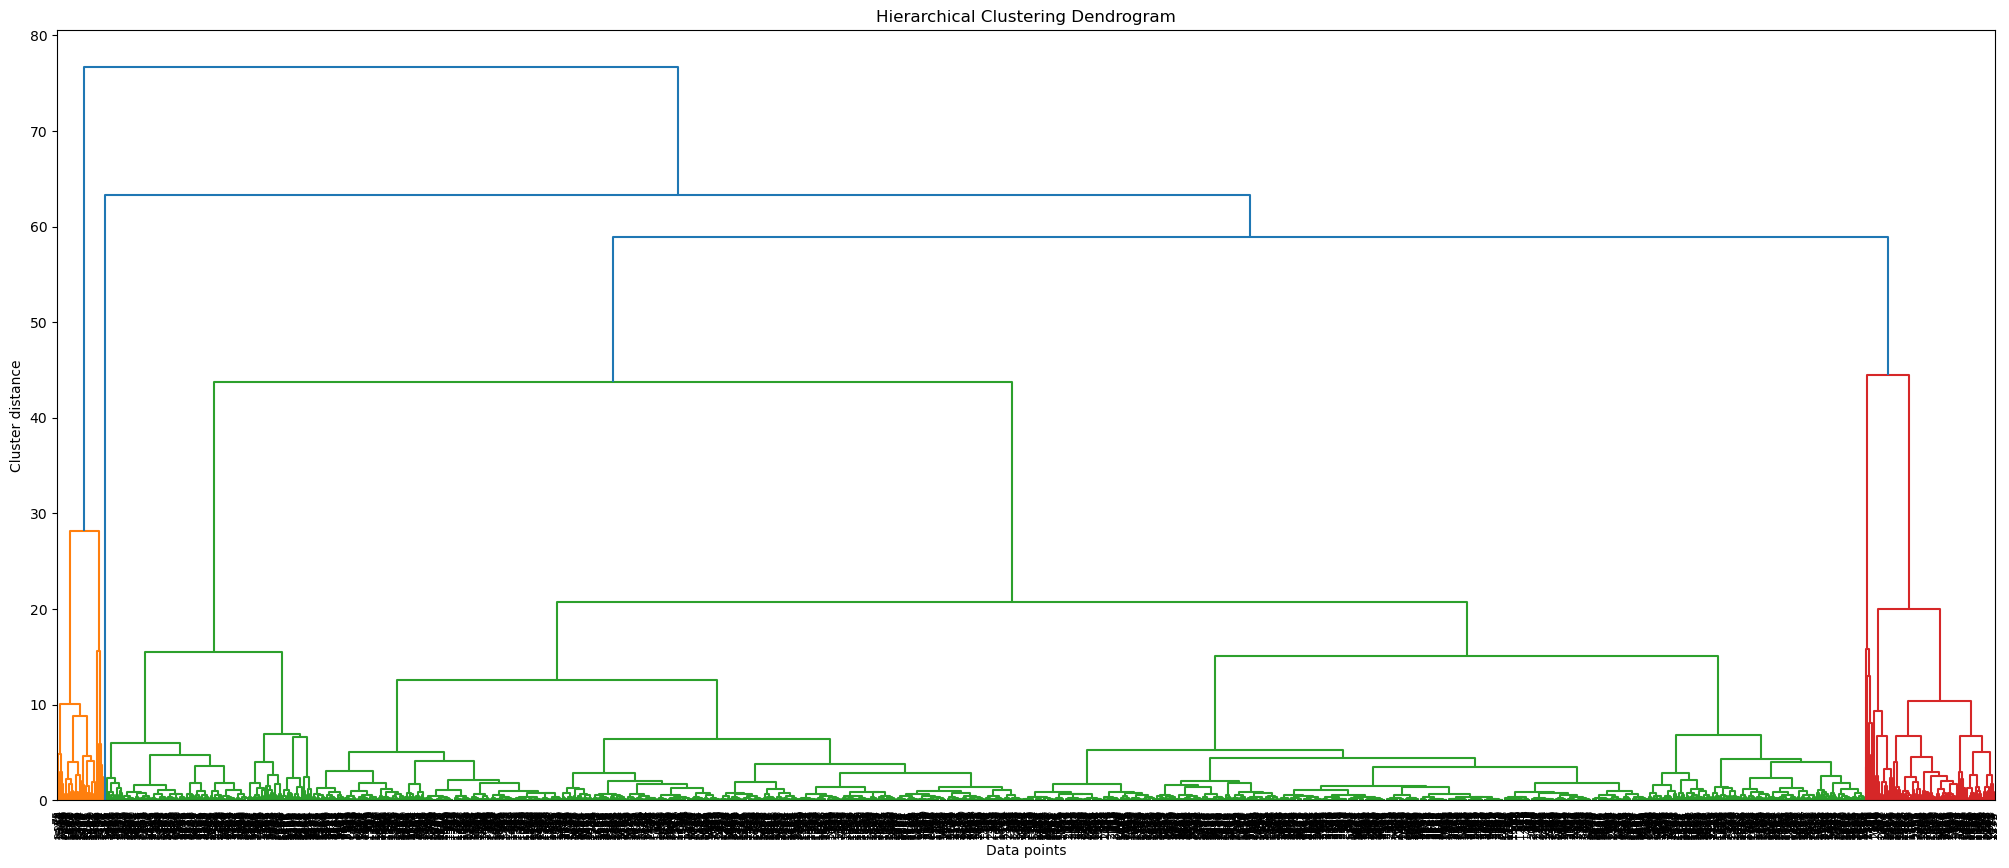

In [5]:
# Perform clustering 
cluster = linkage(energy_potential, method='ward')

# Visualize dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Cluster distance')
dendrogram(cluster,
           #truncate_mode='lastp',
           #p=50,
           leaf_rotation=90,
           leaf_font_size = 8)
plt.show()

In [6]:
# try using elbow? 

### Step 3: Set Up Cluster Interpretation

After determining the optimal number of clusters from the dendrogram, we now assign each county to a cluster using the extracted cluster labels.

To better understand the clustering results, we will:
- Define `num_clusters` as the ideal number of clusters based on the dendrogram created above
- Extract cluster assignment attribute from the hierarchical clustering using `fcluster()` with `criterion = "maxclust"`
- Create a new variable `Cluster` in your cleaned dataframe and assign cluster labels to it
- Compute and print the mean values of the original energy potential features for each cluster.

This summary will help us interpret how counties differ in energy potential across clusters and inform possible next steps for analysis.


In [18]:
# Define ideal number of clusters
num_clusters = 4
# Extract cluster assignment
cluster_value = fcluster(cluster, t=num_clusters, criterion='maxclust')

# Add new column
energy_potential['Cluster'] = cluster_value

# Check new df for cluster info
#eeip_df.head(3)
#eeip_df.shape

# Compute and print the mean values of features by cluster
energy_bycluster = energy_potential.groupby('Cluster')[['utility_pv_technical_generation_potential_mwh',
        'residential_pv_technical_generation_potential_mwh',
        'land_based_wind_technical_generation_potential_mwh',
        'commercial_pv_technical_generation_potential_mwh']].mean().reset_index()
energy_bycluster



/tmp/ipykernel_1758408/3365818183.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_potential['Cluster'] = cluster_value


,Cluster,utility_pv_technical_generation_potential_mwh,residential_pv_technical_generation_potential_mwh,land_based_wind_technical_generation_potential_mwh,commercial_pv_technical_generation_potential_mwh
0,1,4.640211,-0.158880,4.610647,-0.183190
1,2,-0.112789,-0.170711,-0.096350,-0.150347
2,3,-0.158767,2.240598,-0.372775,1.916838
3,4,-0.657721,26.196768,-0.494379,36.307470


### Step 4: Visualizing Energy Potential Across Clusters
Now that we have assigned cluster labels, we want to understand how energy potential differs across clusters. To do this, we will visualize these differences using a grouped bar chart.

Each bar should represent the mean value of an energy potential indicator for a specific cluster. These different patterns of potential is what caused the model to segregate the clusters in the way that it did.

Text(0.5, 1.0, 'Cluserting of Energy Potential Across Counties')

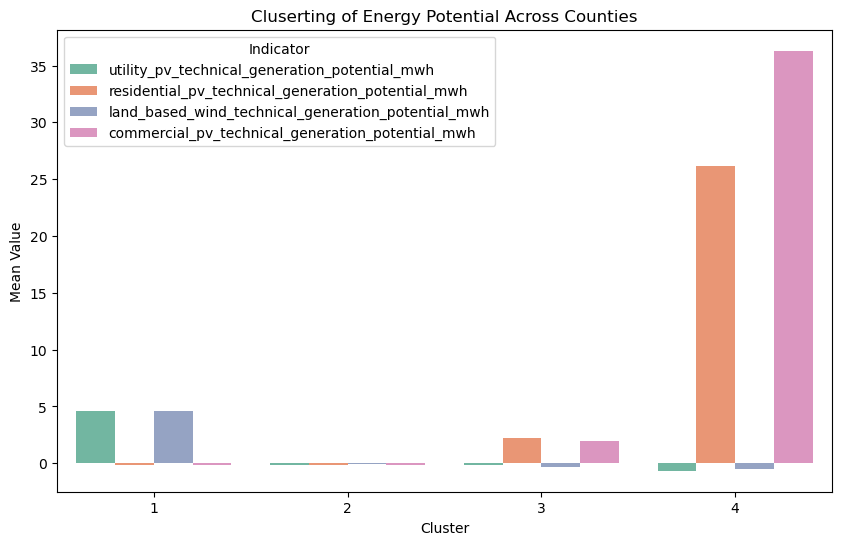

In [45]:
# Prepare for plotting
energy_melt = energy_bycluster.melt(id_vars = 'Cluster',
                               var_name = 'Indicator',
                               value_name = 'Mean Value')
# Create grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=energy_melt,
            x='Cluster',
            y='Mean Value',
            hue="Indicator",
            palette='Set2',
           )
plt.title("Cluserting of Energy Potential Across Counties")

### Step 5: Interpret Clustering Results
Interpret your plot of the resulting clusters.  How would you characterize and compare the four different clusters in terms of their profile of energy generation?

***The clustering results highlight distinct patterns in energy potential across four clusters, each defined by the mean values of four energy indicators: utility PV, residential PV, land-based wind, and commercial PV technical generation potential. Cluster 1 is characterized by high utility PV and land-based wind potential, making it suitable for large-scale energy projects, while residential and commercial PV potential are limited. Cluster 2 shows consistently low values across all indicators, suggesting minimal energy generation potential and limited viability for development. In contrast, Cluster 4 exhibits exceptionally high residential and commercial PV potential, indicating strong suitability for urban or densely populated areas, though it lacks significant utility PV and wind energy potential. Cluster 3 has smaller residential and commercial PV potential than cluster 4, suggesting an area that doesn't receive a lot of sunlight. These insights can guide energy investments and site selection tailored to the strengths of each cluster.***



## Part II: Environmental Justice Metrics
Now it's your turn.

So far, we have clustered counties based on **energy potential**, but energy potential alone does not tell the full story of **energy equity and access**. To deepen the analysis, we need to consider environmental justice (EJ) factors that affect communities’ ability to benefit from renewable energy and the environmental burdens they already experience.

1. Explore EJSCREEN variables:  
   - The EJSCREEN subset of our dataset contains metrics on pollution burden, demographics (population size), and health risks (*lines 31-41 of the ColumnsExplained tab in the metadata sheet linked above*).
   - Identify 1-3 variables that could be important for energy equity analysis.  You could introduce them either as clustering features, as post-clustering variables to help interpret the clusters, or both. 

2. Modify the clustering approach:  
   - Add your selected EJSCREEN variables to our feature set.    
   - Re-run the hierarchical clustering analysis with the expanded dataset (if you added any as clustering features).  

3. Interpret the Results:
   Your interpretation could include considerations such as:
   - How do clusters change when EJSCREEN variables are included?  
   - Are counties with high renewable energy potential also burdened by environmental risks?  
   - What policy recommendations might emerge from these findings?  

**In this part of the analysis, I chose to explore socioeconomic challenges with energy inequities. This feature set includes variables such as `county_pop`, `energy_burden_indicator`, and `lowincome_indicator` and provides a lens to examine how population size, high energy burdens (households spending more than 10% of income on energy costs), and low-income populations intersect to create disparities in energy access and affordability.**   

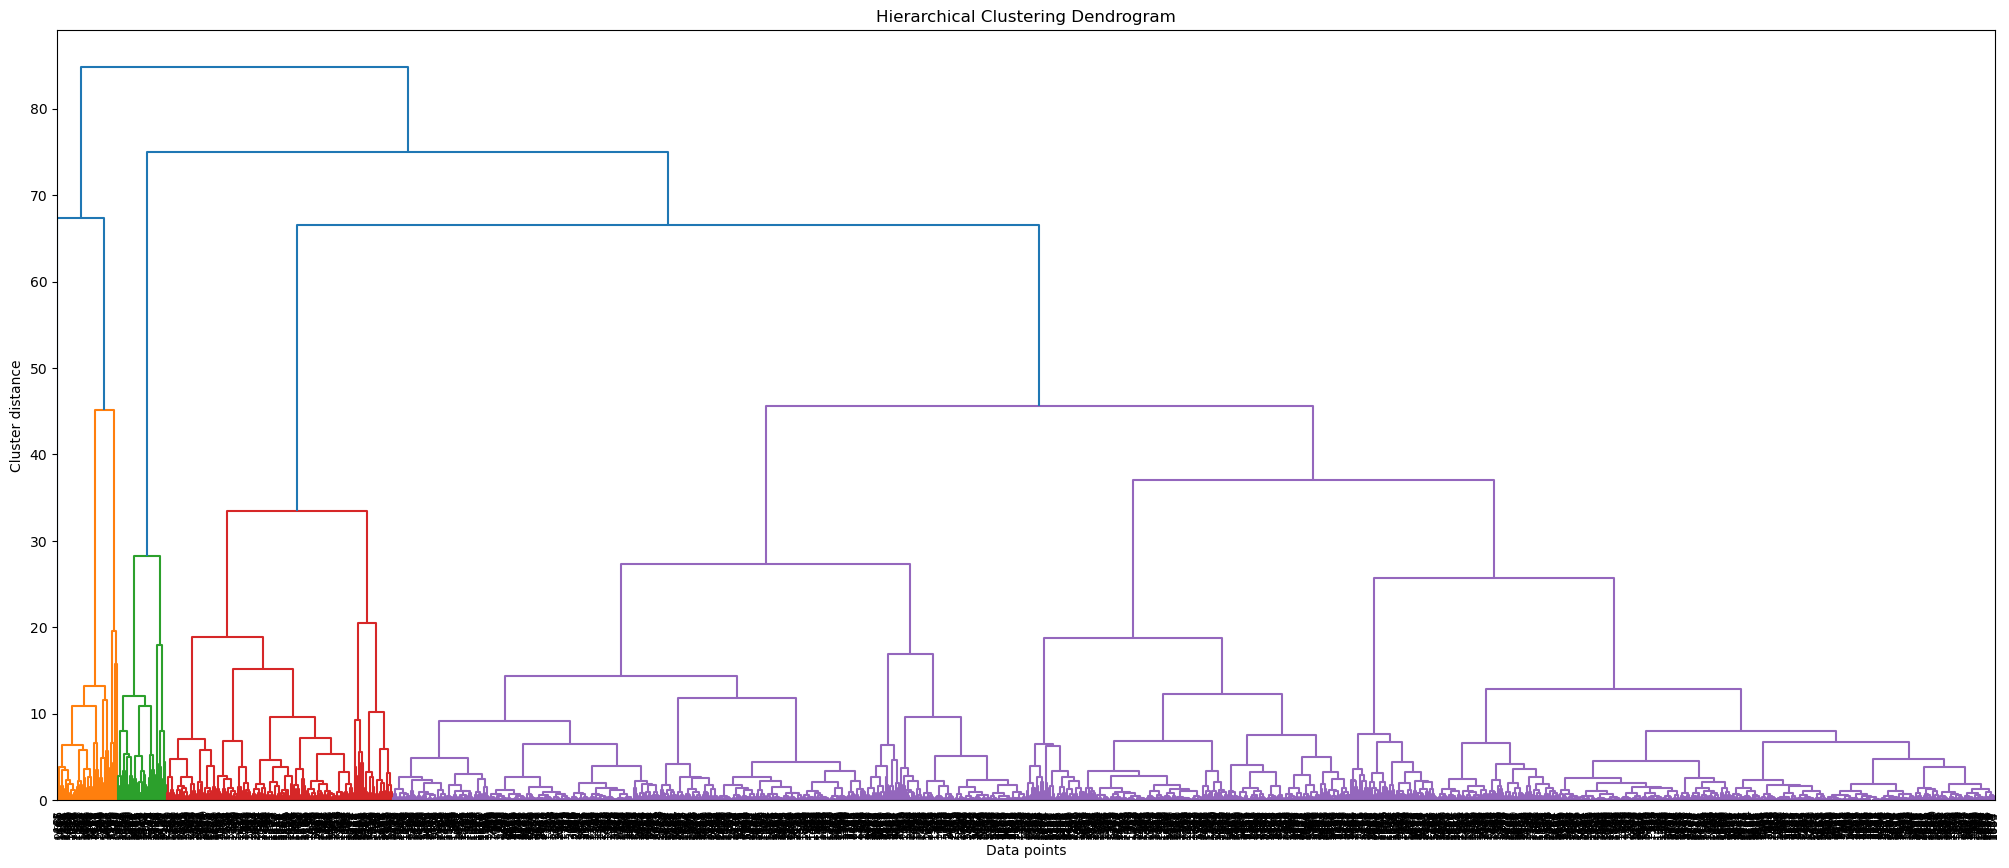

In [32]:
# Select features for part 2 analysis
energy_equity = eeip_df[['utility_pv_technical_generation_potential_mwh',
                         'residential_pv_technical_generation_potential_mwh',
                         'land_based_wind_technical_generation_potential_mwh',
                         'commercial_pv_technical_generation_potential_mwh',
                         'county_pop',
                         'energyburden_indicator',
                         'lowincome_indicator']]

# Perform clustering 
cluster_ej = linkage(energy_equity, method='ward')

# Visualize dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Cluster distance')
dendrogram(cluster_ej,
           #truncate_mode='lastp',
           #p=50,
           leaf_rotation=90,
           leaf_font_size = 8)
plt.show()

### Extract cluster assignment and compute mean values

In [56]:
# Define ideal number of clusters
num_clusters = 5
# Extract cluster assignment
cluster_value = fcluster(cluster_ej, t=num_clusters, criterion='maxclust')

# Add new column
energy_equity['Cluster'] = cluster_value

# Compute and print the mean values of features by cluster
eej_bycluster = energy_equity.groupby('Cluster')[[
    'utility_pv_technical_generation_potential_mwh',
    'residential_pv_technical_generation_potential_mwh',
    'land_based_wind_technical_generation_potential_mwh',
    'commercial_pv_technical_generation_potential_mwh',
    'county_pop',
    'energyburden_indicator',
    'lowincome_indicator']].mean().reset_index()
eej_bycluster

/tmp/ipykernel_1758408/3907815452.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_equity['Cluster'] = cluster_value


,Cluster,utility_pv_technical_generation_potential_mwh,residential_pv_technical_generation_potential_mwh,land_based_wind_technical_generation_potential_mwh,commercial_pv_technical_generation_potential_mwh,county_pop,energyburden_indicator,lowincome_indicator
0,1,-0.071656,3.479952,-0.393879,3.057434,3.467107,-0.225948,-0.489955
1,2,-0.657721,26.196768,-0.494379,36.307470,29.378739,-0.408357,-0.713290
2,3,4.442566,-0.155626,4.469801,-0.181851,-0.153400,0.137301,0.228699
3,4,-0.069462,-0.239650,-0.114584,-0.194019,-0.219142,2.195913,1.109203
4,5,-0.122351,-0.103319,-0.104789,-0.097602,-0.107211,-0.306326,-0.145271


Text(0.5, 1.0, 'Clustering Analysis of Equitable Energy Across Counties')

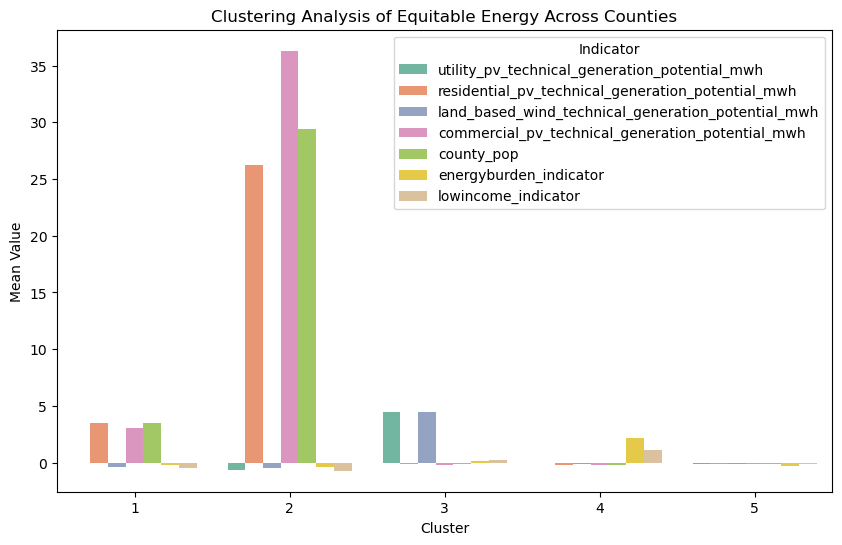

In [57]:
# Visualize clusters
# Prepare for plotting
eej_melt = eej_bycluster.melt(id_vars = 'Cluster',
                               var_name = 'Indicator',
                               value_name = 'Mean Value')
# Create grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=eej_melt,
            x='Cluster',
            y='Mean Value',
            hue="Indicator",
            palette='Set2'
           )
plt.title('Clustering Analysis of Equitable Energy Across Counties')

Which EJSCREEN variable(s) did you add to the analysis? Why did you choose these?  What is the question you are interested in? What did you learn from the analysis

I chose to add `county_pop`, `energy_burden_indicator`, and `lowincome_indicator` to the feature set for clustering in order to explore the disparities in energy access and affordability. 

When Environmental Justice (EJ) variables are included in the clustering analysis, the number of clusters increases by one, reflecting the additional complexity introduced by these socioeconomic factors. However, energy potential remains the dominant feature driving the clustering patterns.

Cluster 4 indicates that counties with high energy burden and low income have low renewable energy potential, highlighting a disparity. 

Counties with high renewable energy potential, particularly for residential and commercial photovoltaic (PV) development, tend to be in areas with larger populations (shown in cluster 2 and 1), likely due to the concentration of urban infrastructure that supports rooftop PV systems. These counties do not exhibit high energy burden or low-income indicators, suggesting that renewable energy development in these areas may not directly address the needs of communities facing the greatest energy inequities.

Cluster 3 is characterized by relatively high value of utility PV and wind generation potential compared to the other clusters. It also suggest lower population with higher energy burden and lower income. 

### Policy Recommendation

For counties grouped together in Cluster 2, policy should leverage high renewable energy potential and promote community solar projects. While these areas have low energy burden and income challenges, care should be taken to ensure that renewable energy development does not disproportionately affect local residents through land use or environmental impacts not analyzed in this study.

For counties grouped together in Cluster 3, ensure local communities benefit from utility PV and wind farm development through job creation and affordable access for low-income households. 

